In [119]:
import pandas as pd
import numpy as np
import random
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import pingouin as pg
from statsmodels.stats.multicomp import MultiComparison

# 4. 분산분석
## 4.1 분산분석 설계
- 여러 모집단 간의 평균의 동일성 검정
- 일원분산분석
    - 집단 간 : 집단을 구분하는 범주형 변수는 한개 이며, 각 참여자는 범주형 변수에 의해 구분되는 두 집단 가운데 하나에 할당 -> 심리치료 a,b
    - 집단 내 : 집단을 구분하는 범주형 변수는 한개 이며, 각 참여자는 범주형 변수에 의해 구분되는 두 집단 모두 할당 -> 같은 심리치료 & 기간 4, 16주
- 이원분산분석 : 집단을 구분하는 범주형 변수는 두 개 이며, 각각 집단 간 요인, 집단 내 요인
    - 주 효과 : 심리치료, 기간 영향
    - 상호작용 효과 : 심리치료 방법 & 기간 간 상호작용
- 공분산분석 : 공변량을 통제하여 독립변수의 순수 영향 검정
- 다변량 분산분석 : 두 개 이상 종속변수 포함
- 다변량 공분산분석 : 두 개 이상 종속변수와 공변량 포함

## 4.2 F검정
- 집단 간 분산 / 집단 내 분산 
    - $집단\ 간\ 분산 = \frac{집단\ 간\ 제곱합}{자유도} = \frac{\sum_g(개별집단\ 표본평균 - 전체표본평균)^2}{g-1} $ : 집단의 표본평균들이 전체 표본의 평균으로부터 떨어져 있는 정도, 표본평균들이 집단 간에 변동하는 정도. 
    - $집단\ 내\ 분산 = \frac{집단\ 내\ 제곱합}{자유도} = \frac{\sum_i \sum_g(x_{ig}-\bar{x_g})^2}{\sum_g(n_g-1)}$ : 집단 내 관측값이 그 집단의 평균으로부터 떨어져있는 정도, 개별 관측값이 해당 집단 내에서 변동하는 정도
- 통계적 유의할 수록 집단 간 평균의 차이가 존재 (독립변수가 종속변수에 영향을 미침)

In [2]:
mstr = ((101.6-108.1)**2*5+(114.6-108.1)**2*5)/(2-1)
mse1 = (4.98**2*4+7.96**2*4)/(4+4)
mse2 = ((95-101.6)**2+(105-101.6)**2+(98-101.6)**2+(103-101.6)**2+(107-101.6)**2+(110-114.6)**2+(125-114.6)**2+(105-114.6)**2+(113-114.6)**2+(120-114.6)**2)/(4+4)
print(mse1, mse2)

44.081 44.05000000000001


In [3]:
f_val = mstr / mse1
f_val

9.584628297906127

In [4]:
1-stats.f.cdf(f_val, dfn=1, dfd=8)

0.014756975246156046

In [5]:
stats.f.ppf(1-0.05, dfn=1, dfd=8)

5.317655071578714

## 4.3 일원분산분석

In [6]:
spray = pd.read_csv("data/InsectSprays.csv")
spray.head()

,rownames,count,spray
0,1,10,A
1,2,7,A
2,3,20,A
3,4,14,A
4,5,14,A


In [7]:
# residual : 집단 내 차이
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

model = ols('count ~ spray', data=spray).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
spray,5.0,2668.833333,533.766667,34.702282,3.182584e-17
Residual,66.0,1015.166667,15.381313,NaN,NaN


- residual 행 : 집단 내의 차이
- sum_sq : 제곱합
- mean_sq : 제곱합 / 자유도 = 분산
- 살충제 간 살충효과의 평균이 같다는 가정 하에서, 표본으로부터 이렇게 큰 F값을 관측할 확률이 너무 작기 때문에, 대립가설 기각

In [8]:
a = spray.loc[spray['spray']=='A']['count']
b = spray.loc[spray['spray']=='B']['count']
c = spray.loc[spray['spray']=='C']['count']
d = spray.loc[spray['spray']=='D']['count']
e = spray.loc[spray['spray']=='E']['count']
f = spray.loc[spray['spray']=='F']['count']
avg = np.mean(spray['count'])

print(np.mean(a), np.mean(b), np.mean(c), np.mean(d), np.mean(e), np.mean(f))
print(np.mean(a)-avg, np.mean(b)-avg, np.mean(c)-avg, np.mean(d)-avg, np.mean(e)-avg, np.mean(f)-avg)

14.5 15.333333333333334 2.0833333333333335 4.916666666666667 3.5 16.666666666666668

5.0 5.833333333333334 -7.416666666666666 -4.583333333333333 -6.0 7.166666666666668


In [9]:
from statsmodels.stats.multicomp import MultiComparison

comp = MultiComparison(spray['count'], spray['spray'])
result = comp.tukeyhsd()
result.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
A,B,0.8333,0.9952,-3.8661,5.5327,False
A,C,-12.4167,0.0,-17.1161,-7.7173,True
A,D,-9.5833,0.0,-14.2827,-4.8839,True
A,E,-11.0,0.0,-15.6994,-6.3006,True
A,F,2.1667,0.7542,-2.5327,6.8661,False
B,C,-13.25,0.0,-17.9494,-8.5506,True
B,D,-10.4167,0.0,-15.1161,-5.7173,True
B,E,-11.8333,0.0,-16.5327,-7.1339,True
B,F,1.3333,0.9603,-3.3661,6.0327,False
C,D,2.8333,0.4921,-1.8661,7.5327,False


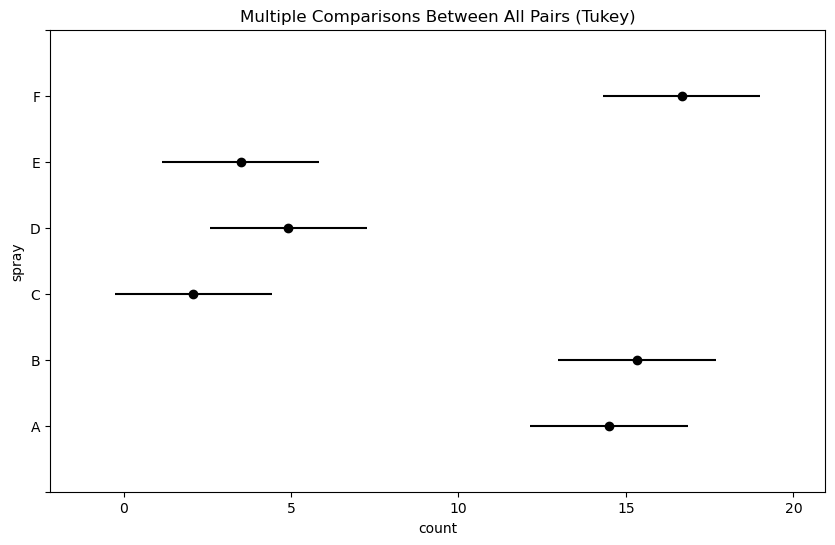

In [10]:
result.plot_simultaneous(ylabel='spray', xlabel='count');

In [11]:
result = comp.allpairtest(stats.ttest_ind, method='bonf')
result[0]

group1,group2,stat,pval,pval_corr,reject
A,B,-0.4535,0.6546,1.0,False
A,C,8.4073,0.0,0.0,True
A,D,6.2144,0.0,0.0,True
A,E,7.5798,0.0,0.0,True
A,F,-0.9619,0.3465,1.0,False
B,C,9.7539,0.0,0.0,True
B,D,7.289,0.0,0.0,True
B,E,8.894,0.0,0.0,True
B,F,-0.6126,0.5464,1.0,False
C,D,-3.0782,0.0055,0.0825,False


- 가정 : 완벽하게 충족하지 않아도, 충족 시 신뢰성 높아짐
1) 정규성 : 종속변수는 정규분포
   => qq-plot, shapiro-wilk
   - 정규성이 크게 이상하지만 않으면 ㅇㅋ
   - 데이터 수가 작을 때는, 이상값에 의한 영향력 확인 필요 => 이상값 제거
3) 등분산성 : 각 집단의 분포는 모두 동일한 분산
   => levene, bartlett

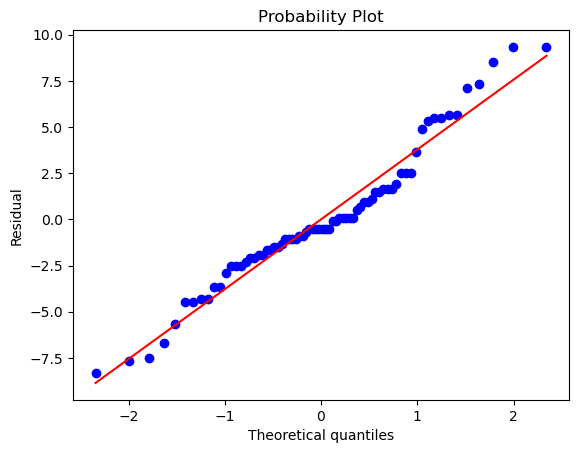

In [12]:
stats.probplot(model.resid, dist=stats.norm, plot=plt);
plt.ylabel('Residual');

In [13]:
# 잔차의 정규성
stats.shapiro(model.resid)
# 변수 왜도 절대값이 2를 넘지 않으면 실시

ShapiroResult(statistic=0.960058867931366, pvalue=0.022260751575231552)

In [14]:
# studentized residuals : 회귀분석에서 특정 데이터 포인트가 모델의 결과에 미치는 영향, 클 수록 큰영향이며 임계값은 -3 ~ 3
result = model.outlier_test(method='bonf', alpha=0.05)
result.sort_values(by='student_resid', ascending=False)

,student_resid,unadj_p,bonf(p)
68,2.590966,0.011804,0.849898
69,2.590966,0.011804,0.849898
7,2.339113,0.022414,1.000000
70,1.996687,0.050050,1.000000
38,1.924666,0.058650,1.000000
...,...,...,...
60,-1.524177,0.132315,1.000000
67,-1.805585,0.075614,1.000000
1,-2.044951,0.044913,1.000000
61,-2.093423,0.040217,1.000000


In [15]:
stats.levene(a,b,c,d,e,f)

LeveneResult(statistic=3.8213563132259276, pvalue=0.004222791138992105)

In [16]:
stats.bartlett(a,b,c,d,e,f)

BartlettResult(statistic=25.959825320368683, pvalue=9.08512233294532e-05)

In [17]:
# https://dschloe.github.io/python/python_edu/05_statistics/chapter_17_1_nonparametric_stat_analysis/#%EA%B0%95%EC%9D%98-%ED%99%8D%EB%B3%B4
# 평균값 차이에 관한 비모수 검정
# 독립성 만족 : 만휘트니
# 독립성 불만족 : 윌콕슨
# 세집단 이상 크루스칼 월리스
# 세집단 이상 비 독립적 : 프리드만

In [18]:
stats.mannwhitneyu(a,b)

MannwhitneyuResult(statistic=62.0, pvalue=0.5812159883741732)

In [120]:
stats.wilcoxon(a,b)

WilcoxonResult(statistic=24.5, pvalue=0.44777761967552365)

In [20]:
stats.kruskal(a,b,c,d,e,f)

KruskalResult(statistic=54.691344622371446, pvalue=1.510844439418511e-10)

In [21]:
stats.friedmanchisquare(a,b,c,d,e,f)

FriedmanchisquareResult(statistic=52.192118226600996, pvalue=4.926831598153926e-10)

In [22]:
# 등분산 미성립 시 from pingouin import welch_anova
pg.welch_anova(dv='count', between='spray', data=spray)

,Source,ddof1,ddof2,F,p-unc,np2
0,spray,5,30.042561,36.065444,7.999379e-12,0.724439


## 4.4 이원분산분석
- 주 효과 검정 : 각 독립변수에 의해 만들어지는 집단 간 평균차이 검정
- 상호작용 효과 검정 : 두 독립변수 조합에 의해 만들어지는 집단 간 평균차이 검정

In [23]:
tooth = pd.read_csv("data/ToothGrowth.csv")
tooth.head()

,rownames,len,supp,dose
0,1,4.2,VC,0.5
1,2,11.5,VC,0.5
2,3,7.3,VC,0.5
3,4,5.8,VC,0.5
4,5,6.4,VC,0.5


In [121]:
for i in range(len(tooth['dose'])):
    if tooth['dose'][i] == 0.5: tooth['dose'][i] = 'low'
    elif tooth['dose'][i] == 1.0: tooth['dose'][i] = 'med'
    else : tooth['dose'][i] = 'high'
        
tooth['dose'].value_counts()

dose
high    60
Name: count, dtype: int64

In [25]:
tooth.groupby(['supp', 'dose']).count()

rownames  len
supp dose               
OJ   high        10   10
     low         10   10
     med         10   10
VC   high        10   10
     low         10   10
     med         10   10

In [26]:
tooth.groupby(['supp', 'dose']).mean()

rownames    len
supp dose                 
OJ   high      55.5  26.06
     low       35.5  13.23
     med       45.5  22.70
VC   high      25.5  26.14
     low        5.5   7.98
     med       15.5  16.77

In [27]:
tooth.groupby(['supp', 'dose']).std()

rownames       len
supp dose                    
OJ   high   3.02765  2.655058
     low    3.02765  4.459709
     med    3.02765  3.910953
VC   high   3.02765  4.797731
     low    3.02765  2.746634
     med    3.02765  2.515309

In [28]:
model = ols('len ~ supp + dose', data=tooth).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
supp,1.0,205.350000,205.350000,14.016638,4.292793e-04
dose,2.0,2426.434333,1213.217167,82.810935,1.871163e-17
Residual,56.0,820.425000,14.650446,NaN,NaN


In [29]:
model = ols('len ~ supp + dose + supp * dose', data=tooth).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
supp,1.0,205.350000,205.350000,15.571979,2.311828e-04
dose,2.0,2426.434333,1213.217167,91.999965,4.046291e-18
supp:dose,2.0,108.319000,54.159500,4.106991,2.186027e-02
Residual,54.0,712.106000,13.187148,NaN,NaN


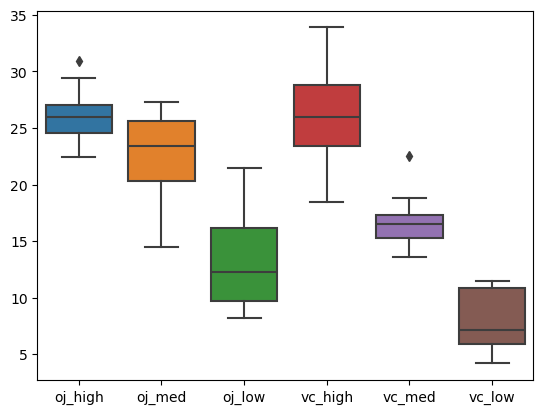

In [30]:
oj_high = tooth.loc[(tooth['dose'] == 'high') & (tooth['supp'] == 'OJ')]['len'].reset_index(drop=True)
oj_med = tooth.loc[(tooth['dose'] == 'med') & (tooth['supp'] == 'OJ')]['len'].reset_index(drop=True)
oj_low = tooth.loc[(tooth['dose'] == 'low') & (tooth['supp'] == 'OJ')]['len'].reset_index(drop=True)

vc_high = tooth.loc[(tooth['dose'] == 'high') & (tooth['supp'] == 'VC')]['len'].reset_index(drop=True)
vc_med = tooth.loc[(tooth['dose'] == 'med') & (tooth['supp'] == 'VC')]['len'].reset_index(drop=True)
vc_low = tooth.loc[(tooth['dose'] == 'low') & (tooth['supp'] == 'VC')]['len'].reset_index(drop=True)

res = np.zeros((len(oj_high), 6))
res[:,0] = oj_high; res[:,1] = oj_med; res[:,2] = oj_low;
res[:,3] = vc_high; res[:,4] = vc_med; res[:,5] = vc_low;
res = pd.DataFrame(data=res, columns=['oj_high', 'oj_med', 'oj_low', 'vc_high', 'vc_med', 'vc_low']);

sns.boxplot(data=res);

In [31]:
tooth.head()

,rownames,len,supp,dose
0,1,4.2,VC,low
1,2,11.5,VC,low
2,3,7.3,VC,low
3,4,5.8,VC,low
4,5,6.4,VC,low


In [32]:
# new feature for two-way ANOVA
tooth['combi'] = tooth['supp'] + ' & ' + tooth['dose']

comp = MultiComparison(tooth['len'], tooth['combi'])
result = comp.tukeyhsd()
result.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
OJ & high,OJ & low,-12.83,0.0,-17.6281,-8.0319,True
OJ & high,OJ & med,-3.36,0.3187,-8.1581,1.4381,False
OJ & high,VC & high,0.08,1.0,-4.7181,4.8781,False
OJ & high,VC & low,-18.08,0.0,-22.8781,-13.2819,True
OJ & high,VC & med,-9.29,0.0,-14.0881,-4.4919,True
OJ & low,OJ & med,9.47,0.0,4.6719,14.2681,True
OJ & low,VC & high,12.91,0.0,8.1119,17.7081,True
OJ & low,VC & low,-5.25,0.0243,-10.0481,-0.4519,True
OJ & low,VC & med,3.54,0.264,-1.2581,8.3381,False
OJ & med,VC & high,3.44,0.2936,-1.3581,8.2381,False


## 4.5 공분산분석
- 공변량을 추가하여 분산분석모델 확장, 공변량을 통제하여 독립변수의 순수한 영향을 검정
- 공변량은 연속형 변수 가정

In [33]:
drink = pd.read_csv("data/ancova_sample.csv")
drink.head()

,ID,Flavour,Sweet,Satisfaction
0,ID_1,A,0.5,3.9
1,ID_2,B,1.6,3.7
2,ID_3,A,0.6,5.3
3,ID_4,C,3.2,6.5
4,ID_5,B,1.8,2.7


In [34]:
drink.groupby(['Flavour']).count()

,ID,Sweet,Satisfaction
Flavour,,,
A,30,30,30
B,30,30,30
C,30,30,30


In [35]:
drink[['Flavour','Satisfaction']].groupby(['Flavour']).mean()

,Satisfaction
Flavour,
A,4.706667
B,3.293333
C,5.943333


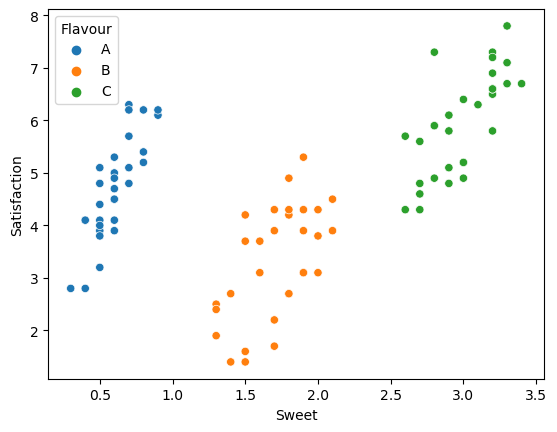

In [36]:
sns.scatterplot(data=drink, x='Sweet', y='Satisfaction', hue='Flavour');

In [37]:
pg.normality(drink['Satisfaction'])

,W,pval,normal
Satisfaction,0.984999,0.39025,True


In [38]:
# 중요변수만 투입
pg.anova(dv='Satisfaction', between='Flavour', data=drink, detailed=True).round(3)

,Source,SS,DF,MS,F,p-unc,np2
0,Flavour,105.494,2,52.747,51.578,0.0,0.542
1,Within,88.971,87,1.023,NaN,NaN,NaN


In [39]:
# 통제변수 고려
pg.ancova(data=drink, dv='Satisfaction', covar='Sweet', between='Flavour').round(3)

,Source,SS,DF,F,p-unc,np2
0,Flavour,106.116,2,95.374,0.0,0.689
1,Sweet,41.128,1,73.929,0.0,0.462
2,Residual,47.843,86,NaN,NaN,NaN


종속변수와 관련된 변수를 통제함으로써 통계적 유의성에 변화가 생길 수 있음
- 음료의 만족감과 향의 관계를 확인하는 과정에서, 당도를 공변량으로 사용한 공분산분석 시행. 둘 모두 유의한 영향을 주는 것 확인

## 4.6 반복측정 분산분석
- 동일한 대상에 대해 여러번 반복측정하여 반복측정 집단 간에 차이가 존재하는지 검정
- 집단 내 요인 : 동일한 대상에 대해서 반복 측정한 결과를 구분하는 변수
- 집단 간 요인 : 대상을 서로 구분되는 집단으로 분할하는 변수

In [110]:
co2 = pd.read_csv("data/CO2.csv", index_col='rownames')
co2.info()

<class 'pandas.core.frame.DataFrame'>

Index: 84 entries, 1 to 84

Data columns (total 5 columns):

 #   Column     Non-Null Count  Dtype  

---  ------     --------------  -----  

 0   Plant      84 non-null     object 

 1   Type       84 non-null     object 

 2   Treatment  84 non-null     object 

 3   conc       84 non-null     int64  

 4   uptake     84 non-null     float64

dtypes: float64(1), int64(1), object(3)

memory usage: 3.9+ KB


In [111]:
co2.head()

,Plant,Type,Treatment,conc,uptake
rownames,,,,,
1,Qn1,Quebec,nonchilled,95,16.0
2,Qn1,Quebec,nonchilled,175,30.4
3,Qn1,Quebec,nonchilled,250,34.8
4,Qn1,Quebec,nonchilled,350,37.2
5,Qn1,Quebec,nonchilled,500,35.3


In [112]:
co2sub = co2.loc[co2['Treatment']=='chilled'].reset_index(drop=True)
co2sub['conc'] = co2sub['conc'].astype(str)
co2sub.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 42 entries, 0 to 41

Data columns (total 5 columns):

 #   Column     Non-Null Count  Dtype  

---  ------     --------------  -----  

 0   Plant      42 non-null     object 

 1   Type       42 non-null     object 

 2   Treatment  42 non-null     object 

 3   conc       42 non-null     object 

 4   uptake     42 non-null     float64

dtypes: float64(1), object(4)

memory usage: 1.8+ KB


In [113]:
co2sub.head()

,Plant,Type,Treatment,conc,uptake
0,Qc1,Quebec,chilled,95,14.2
1,Qc1,Quebec,chilled,175,24.1
2,Qc1,Quebec,chilled,250,30.3
3,Qc1,Quebec,chilled,350,34.6
4,Qc1,Quebec,chilled,500,32.5


- 반복측정 일원분산분석 : y ~ W + Error(Subject/W)
- 반복측정 이원분산분석 : y ~ B * W + Error(Subject/W)
  - w : 집단 내 요인 / b : 집단 간 요인 / Subject : 각 측정 대상에 대한 식별자 변수 

In [124]:
co2sub[['Type', 'conc', 'uptake']].groupby(['Type','conc']).describe()

uptake                                                     
                  count       mean       std   min    25%   50%    75%   max
Type        conc                                                            
Mississippi 1000    3.0  18.733333  3.883727  14.4  17.15  19.9  20.90  21.9
            175     3.0  14.766667  3.302020  11.4  13.15  14.9  16.45  18.0
            250     3.0  16.100000  3.292416  12.3  15.10  17.9  18.00  18.1
            350     3.0  16.600000  3.157531  13.0  15.45  17.9  18.40  18.9
            500     3.0  16.633333  3.667879  12.5  15.20  17.9  18.70  19.5
            675     3.0  18.266667  4.285246  13.7  16.30  18.9  20.55  22.2
            95      3.0   9.600000  1.646208   7.7   9.10  10.5  10.55  10.6
Quebec      1000    3.0  40.833333  1.913984  38.7  40.05  41.4  41.90  42.4
            175     3.0  24.133333  3.150132  21.0  22.55  24.1  25.70  27.3
            250     3.0  34.466667  3.927255  30.3  32.65  35.0  36.55  38.1
            350     3.0  35.800000  2.615339  34.0  34.30  34.6  36.70  38.8
            500     3.0  36.666667  3.611556  32.5  35.55  38.6  38.75  38.9
            675     3.0  37.500000  2.100000  35.4  36.45  37.5  38.55  39.6
            95      3.0  12.866667  3.121431   9.3  11.75  14.2  14.65  15.1

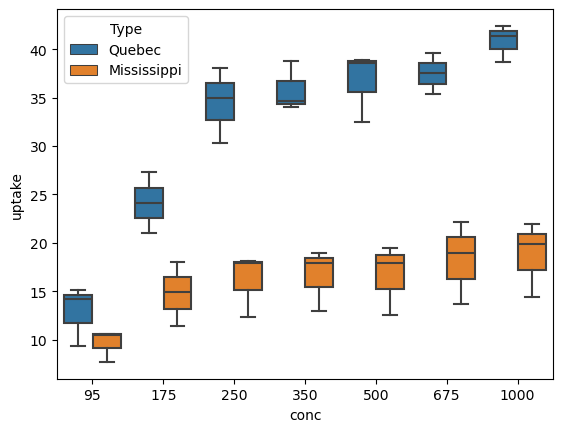

In [127]:
sns.boxplot(data=co2sub, x='conc', y='uptake', hue='Type');

In [122]:
temp = {'id': list(np.arange(1,21,1)),
       'none_clear' : [46,44,51,34,55,29,34,44,50,41,46,47,38,38,50,46,44,38,40,46],
        'low_clear' : [55,61,59,45,58,64,60,57,61,63,58,55,44,47,20,51,54,48,50,52],
        'med_clear' : [68,72,79,51,45,74,79,66,59,68,72,74,70,61,58,74,78,69,70,66],
        'high_clear' : [44,51,38,37,45,39,46,51,40,50,47,55,46,53,51,42,46,51,47,41],
        'none_blur' : [15,20,21,26,11,19,16,21,22,18,17,20,24,25,19,17,17,21,22,25],
        'low_blur' : [31,34,28,30,34,33,34,36,26,29,30,27,31,27,30,26,28,20,14,24],
        'med_blur' : [70,72,66,63,74,76,60,58,74,62,68,65,66,70,74,68,69,71,64,69],
        'high_blur' : [41,46,47,38,38,50,46,44,38,40,46,40,38,42,47,36,25,39,41,42],
       }
df = pd.DataFrame(temp)

temp_stack = df.set_index('id').stack()
temp_stack = pd.DataFrame(temp_stack).reset_index().rename(columns={0:'value'})

temp_stack['noise'] = 0
temp_stack['image'] = 0

for i in range(len(temp_stack)):
    temp_stack['noise'][i] = temp_stack['level_1'][i].split('_')[0]
    temp_stack['image'][i] = temp_stack['level_1'][i].split('_')[1]

temp_stack.drop('level_1', axis=1, inplace=True)
temp_stack.head()

,id,value,noise,image
0,1,46,none,clear
1,1,55,low,clear
2,1,68,med,clear
3,1,44,high,clear
4,1,15,none,blur


In [130]:
# pval 0.05이상이어서 구형성 만족
# 구형성 : 반복적으로 측정되는 자료들의 시차에 따른 분산이 동일하다는 가정
pg.sphericity(data=temp_stack, dv='value', within=['noise', 'image'], subject='id')

SpherResults(spher=True, W=0.7455943237608619, chi2=5.202777085012786, dof=5, pval=0.39227411821127384)

In [131]:
pg.rm_anova(dv='value', within=['noise', 'image'], subject='id', data=temp_stack, correction=False)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,noise,28797.06875,3,57,9599.022917,230.177265,8.182709e-32,5.515336e-28,0.816000,0.870328
1,image,6825.15625,1,19,6825.156250,134.073051,4.724585e-10,4.724585e-10,0.512453,1.000000
2,noise * image,4814.26875,3,57,1604.756250,37.140254,1.948445e-13,1.252775e-11,0.425751,0.839880


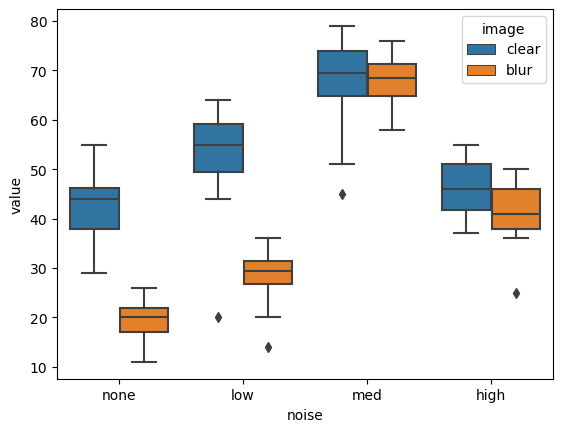

In [128]:
sns.boxplot(data=temp_stack, x='noise', y='value', hue='image');

In [133]:
pg.pairwise_ttests(dv='value', within=['noise', 'image'], subject='id', data=temp_stack)

,Contrast,noise,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,noise,-,high,low,True,True,1.718353,19.0,two-sided,1.019854e-01,0.806,0.536719
1,noise,-,high,med,True,True,-18.973291,19.0,two-sided,8.282787e-14,7.206e+10,-5.665716
2,noise,-,high,none,True,True,10.692938,19.0,two-sided,1.769799e-09,6.272e+06,3.426293
3,noise,-,low,med,True,True,-17.434906,19.0,two-sided,3.799929e-13,1.717e+10,-4.976125
4,noise,-,low,none,True,True,5.611099,19.0,two-sided,2.069127e-05,1142.119,1.935429
5,noise,-,med,none,True,True,26.995410,19.0,two-sided,1.286364e-16,3.22e+13,9.178557
6,image,-,blur,clear,True,True,-11.578992,19.0,two-sided,4.724585e-10,2.15e+07,-3.881735
7,noise * image,high,blur,clear,True,True,-2.869628,19.0,two-sided,9.811338e-03,5.205,-0.880365
8,noise * image,low,blur,clear,True,True,-10.891012,19.0,two-sided,1.308329e-09,8.312e+06,-3.070213
9,noise * image,med,blur,clear,True,True,0.117856,19.0,two-sided,9.074188e-01,0.234,0.040435


## 4.7 다변량 분산분석
- 두 개 이상의 종속변수가 있을 경우, 집단별 차이를 동시에 검정

In [137]:
skulls = pd.read_csv("data/skulls.csv", index_col='rownames')
skulls = skulls.sample(n=10)
skulls.info()

<class 'pandas.core.frame.DataFrame'>

Index: 10 entries, 57 to 88

Data columns (total 5 columns):

 #   Column  Non-Null Count  Dtype 

---  ------  --------------  ----- 

 0   epoch   10 non-null     object

 1   mb      10 non-null     int64 

 2   bh      10 non-null     int64 

 3   bl      10 non-null     int64 

 4   nh      10 non-null     int64 

dtypes: int64(4), object(1)

memory usage: 480.0+ bytes


In [136]:
skulls.head()

,epoch,mb,bh,bl,nh
rownames,,,,,
1,c4000BC,131,138,89,49
2,c4000BC,125,131,92,48
3,c4000BC,131,132,99,50
4,c4000BC,119,132,96,44
5,c4000BC,136,143,100,54


In [140]:
skulls['epoch'].value_counts()

epoch
c3300BC    3
cAD150     2
c200BC     2
c4000BC    2
c1850BC    1
Name: count, dtype: int64

In [141]:
y = skulls[['mb', 'bh', 'bl', 'nh']]
y.head()

,mb,bh,bl,nh
rownames,,,,
57,132,130,104,50
127,136,138,97,58
56,131,134,90,53
113,141,131,97,53
138,137,135,96,54


In [143]:
skulls.groupby(['epoch']).mean()

,mb,bh,bl,nh
epoch,,,,
c1850BC,133.000000,131.0,96.000000,49.0
c200BC,136.500000,132.0,93.500000,53.0
c3300BC,133.666667,131.0,100.333333,52.0
c4000BC,134.000000,137.0,95.500000,50.0
cAD150,136.500000,136.5,96.500000,56.0


In [149]:
# Pillai's trace
from statsmodels.multivariate.manova import MANOVA

fit = MANOVA.from_formula('mb + bh + bl + nh ~ epoch', data=skulls)
print(fit.mv_test())

                    Multivariate linear model


                                                                 

-----------------------------------------------------------------

       Intercept          Value    Num DF Den DF  F Value  Pr > F

-----------------------------------------------------------------

          Wilks' lambda     0.0001 4.0000 2.0000 8499.5766 0.0001

         Pillai's trace     0.9999 4.0000 2.0000 8499.5766 0.0001

 Hotelling-Lawley trace 16999.1533 4.0000 1.0000 4249.7883 0.0115

    Roy's greatest root 16999.1533 4.0000 2.0000 8499.5766 0.0001

-----------------------------------------------------------------

                                                                 

-----------------------------------------------------------------

            epoch           Value   Num DF  Den DF F Value Pr > F

-----------------------------------------------------------------

             Wilks' lambda  0.0023 16.0000  6.7477  2.6460 0.1025

            Pi

In [155]:
skulls = pd.read_csv("data/skulls.csv", index_col='rownames')

In [156]:
# 사후분석용 각각의 ANOVA

model = ols('mb ~ epoch', data=skulls).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
epoch,4.0,502.826667,125.706667,5.954613,0.000183
Residual,145.0,3061.066667,21.110805,NaN,NaN


In [157]:
model = ols('bh ~ epoch', data=skulls).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
epoch,4.0,229.906667,57.476667,2.44742,0.04897
Residual,145.0,3405.266667,23.484598,NaN,NaN


In [158]:
model = ols('bl ~ epoch', data=skulls).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
epoch,4.0,803.293333,200.823333,8.305665,0.000005
Residual,145.0,3505.966667,24.179080,NaN,NaN


In [159]:
model = ols('nh ~ epoch', data=skulls).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
epoch,4.0,61.200000,15.300000,1.506997,0.203179
Residual,145.0,1472.133333,10.152644,NaN,NaN
